# **K-NN + PCA**

## **Setup**

In [1]:
import sys 
assert sys.version_info >= (3, 5)
import os 

import warnings
warnings.filterwarnings('ignore') 

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
import matplotlib.cm as cm 
%matplotlib inline 
import seaborn as sns

import sklearn 
assert sklearn.__version__ >= "0.20"
from sklearn import svm 
from sklearn.model_selection import GridSearchCV 
from bayes_opt import BayesianOptimization
from sklearn.model_selection import train_test_split, learning_curve, KFold 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.decomposition import PCA

from collections import Counter 

import math 

import keras 
from keras.datasets import mnist
from keras.utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [2]:
import os

current_directory = os.getcwd()
print("Current Directory:", current_directory)

if not current_directory.endswith('/Handwritten-digit-recognition'):
    path_parts = current_directory.split(os.sep)

    for i in range(len(path_parts), 0, -1):
        if path_parts[i - 1] == 'Handwritten-digit-recognition':
            new_directory = os.sep.join(path_parts[:i])
            os.chdir(new_directory)
            break
    else:
        print("Directory 'Handwritten-digit-recognition' not found in the current path.")
else:
    print("Already in the correct directory.")

print("New Directory:", os.getcwd())


Current Directory: c:\Users\ASUS\OneDrive\Desktop\Handwritten-digit-recognition\Src
New Directory: c:\Users\ASUS\OneDrive\Desktop\Handwritten-digit-recognition


In [3]:
# Where to save the figures 
PROJECT_ROOT_DIR = "."
FOLDER_ID = "handwritten digit recognition"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", FOLDER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure" , fig_id)
    if tight_layout: 
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## **Data preparation**

### **Load dataset**

In [4]:
train = pd.read_csv('datasets/digit-recognizer/train.csv')
test = pd.read_csv('datasets/digit-recognizer/test.csv')
sub = pd.read_csv('datasets/digit-recognizer/sample_submission.csv')

print("Loading data successful!!")

Loading data successful!!


### **Load more data sets**

In [5]:
(x_train1, y_train1), (x_test1, y_test1) = mnist.load_data()

x_train1 = np.concatenate([x_train1, x_test1], axis=0)
y_train1 = np.concatenate([y_train1, y_test1], axis=0)

X_train1 = x_train1.reshape(-1, 28*28)
Y_train1 = y_train1
Y_train1.shape, X_train1.shape
train1 = pd.DataFrame(np.column_stack((Y_train1, X_train1)), columns=train.columns)

In [6]:
# Merging all the data we got 
train = pd.DataFrame(np.concatenate((train, train1)), columns = train.columns)

In [7]:
X_train = train.drop(labels=["label"], axis=1).values
Y_train = train["label"].values
X_test = test.values 

## **Dimensionality Reduction Using PCA**

Saving figure dimensionality reduction using pca


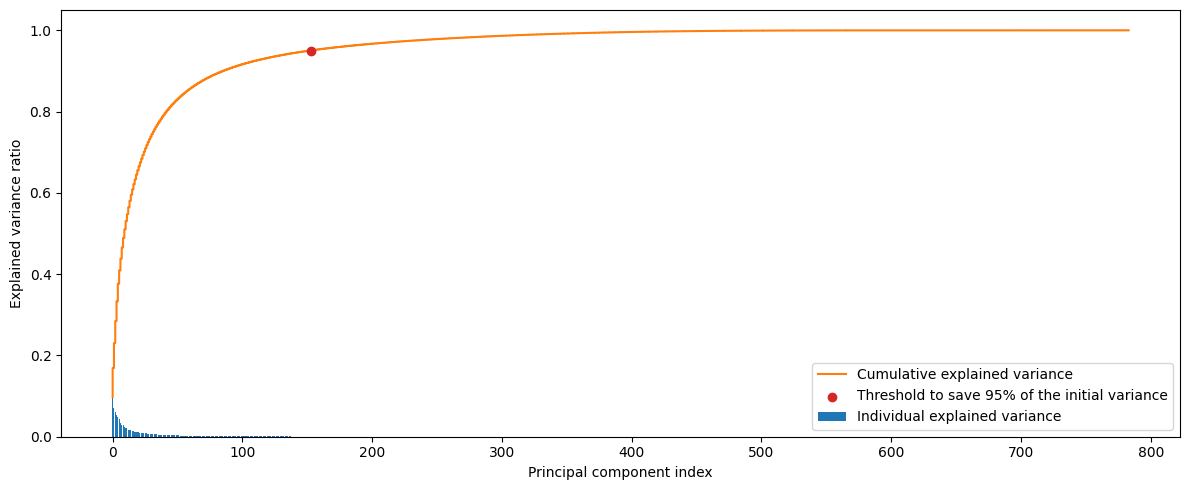

In [8]:
# Detection of the number of component needed
pca = PCA()
pca.fit(X_train)

# Explained variance ratio analysis
exp_var = pca.explained_variance_ratio_
cumsum_exp_var = np.cumsum(exp_var)

plt.figure(figsize=(12,5))
plt.bar(
    range(0, len(exp_var)), 
    exp_var, 
    label='Individual explained variance', 
    color='C0'
)
plt.step(
    range(0, len(cumsum_exp_var)), 
    cumsum_exp_var, 
    label='Cumulative explained variance', 
    color='C1'
)
plt.scatter(
    np.argmax(np.cumsum(exp_var) > 0.95), 
    0.95, 
    label='Threshold to save 95% of the initial variance', 
    c='C3',
    zorder=3
)
plt.xlabel("Principal component index")
plt.ylabel("Explained variance ratio")
plt.legend()
save_fig("dimensionality reduction using pca")
plt.show()


In [9]:
n_components = np.argmax(np.cumsum(exp_var) > 0.95)
n_components

153

In [10]:
# Define and train PCA with 153 components (preserved 95% of the variance)
pca = PCA(n_components=153)
pca.fit(X_train)

# Transform our train and test data
X_train_reduced = pca.transform(X_train)
X_test_reduced = pca.transform(X_test)

In [11]:
X_train_reduced.shape, X_test_reduced.shape

((112000, 153), (28000, 153))

In [12]:
import random 
def compare_images(
    data: np.array,
    data_recovered: np.array,
    target: np.array
) -> None:
    """
    This function take the a random image from the 
    the array that contains recovered after PCA, 
    and the array that contains images, reshape it
    and plot both with as title the truth value of 
    the images.
    """
    
    idx = random.randint(0, len(data))
    
    # Plot
    plt.subplot(1, 2, 1)
    plt.imshow(data[idx, :].reshape((28,28)))
    plt.title(f"Original \n Real number: {target[idx]}")
    plt.subplot(1, 2, 2)
    plt.imshow(data_recovered[idx, :].reshape((28,28)))
    plt.title(f"Compressed \n Real number: {target[idx]}")
    save_fig("random_compressed_image")
    plt.show()

Saving figure random_compressed_image


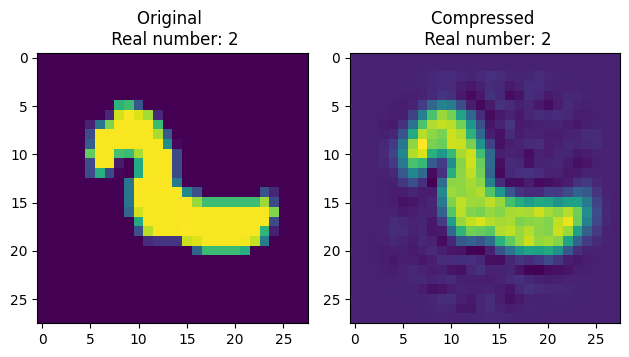

In [13]:
X_train_recovered = pca.inverse_transform(X_train_reduced)

compare_images(X_train, X_train_recovered, Y_train)

We can see that there is a slight image quality loss, but the digit is still mostly intact.

## **Build the model**

### **Split training and validation sets**

In [14]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train_reduced, Y_train, test_size = 0.1, random_state=42)

In [15]:
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

((100800, 153), (11200, 153), (100800,), (11200,))

### **Grid Search k-NN for optimal k**


We will train the model using GridSearchCV

In [16]:
# # Define the parameters grid 
# parameters = [{
#     'n_neighbors' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
#     'weights' : ['uniform', 'distance'],
# }]

# # Create GridSearchCV object 
# grid_search = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=parameters, scoring='accuracy', cv=5, verbose=2)  

# # Fit the grid search to the data
# grid_search.fit(X_train, Y_train)

# # Get the best parameters
# best_parameters = grid_search.best_params_

# # Output the best parameters
# print(best_parameters)

### {'n_neighbors': 6, 'weights': 'distance'}

In [17]:
knn = KNeighborsClassifier(n_neighbors=6, weights='distance')
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_val)

## **Save the model**

In [19]:
from joblib import dump
dump(knn, "FinalModels/K-NN + PCA.joblib")
print("Save successful!!")

Save successful!!


## **Load the model**

In [20]:
from joblib import load 
knn = load('FinalModels/K-NN + PCA.joblib')

### **Predict some examples**

In [21]:
prediction = knn.predict(X_test_reduced)

2


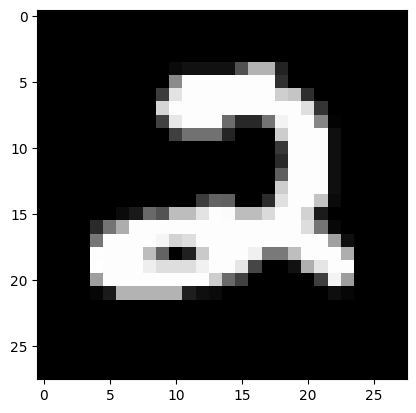

9


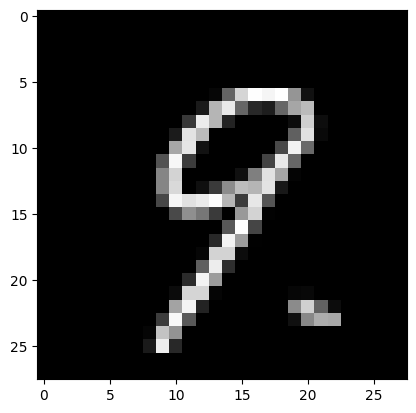

3


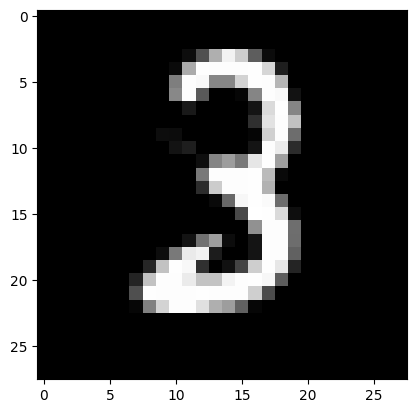

0


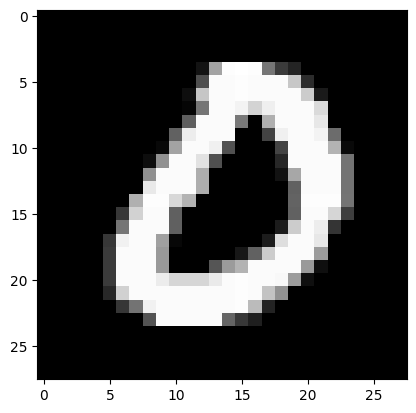

0


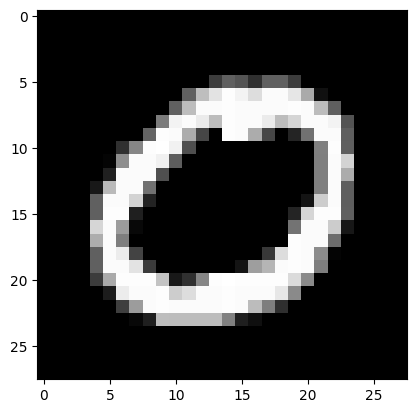

5


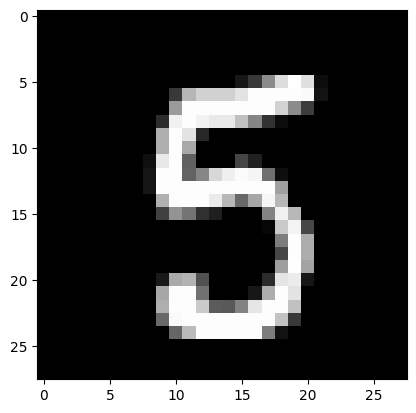

4


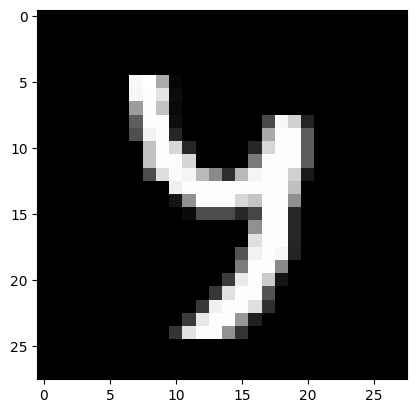

4


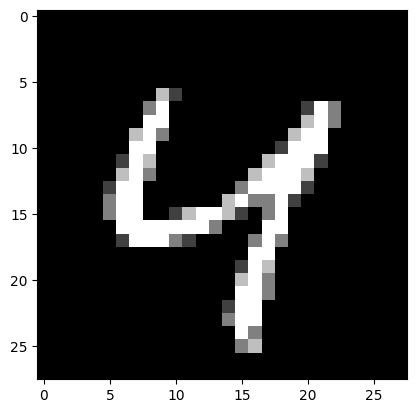

3


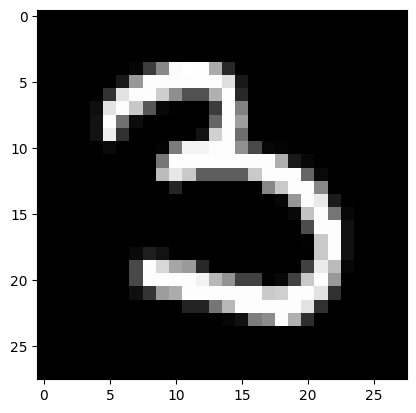

9


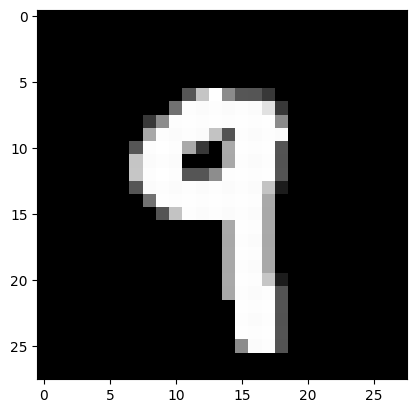

9


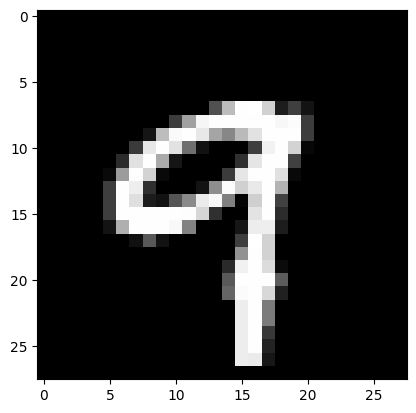

1


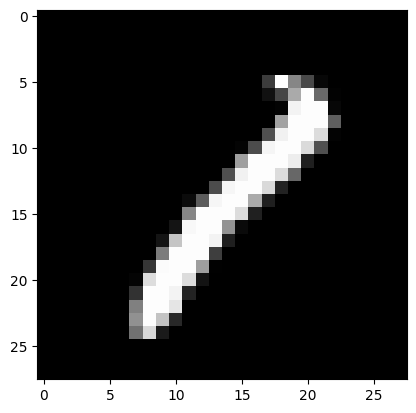

7


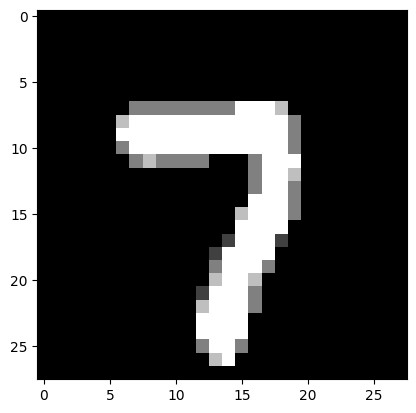

2


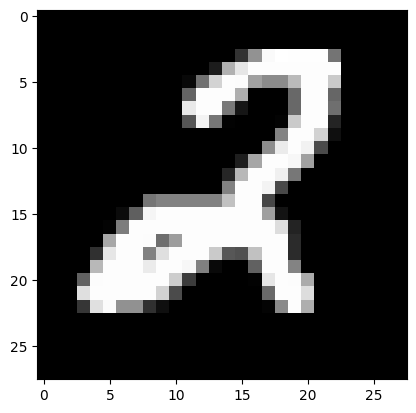

4


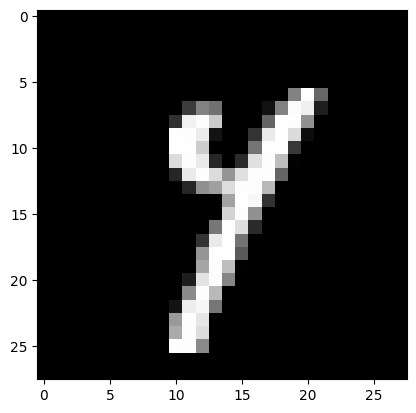

7


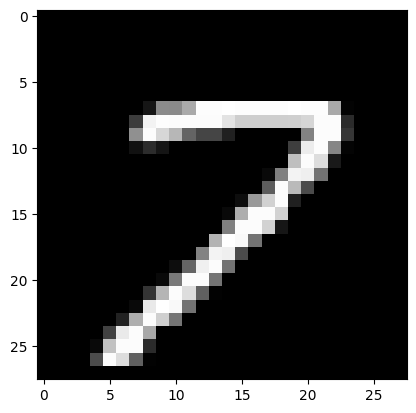

4


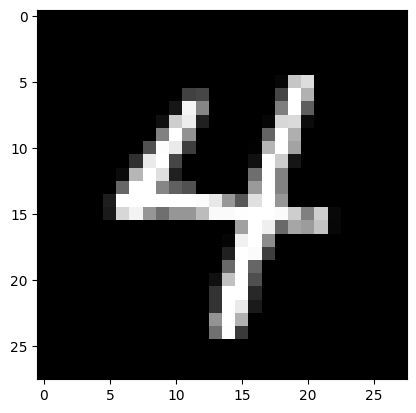

6


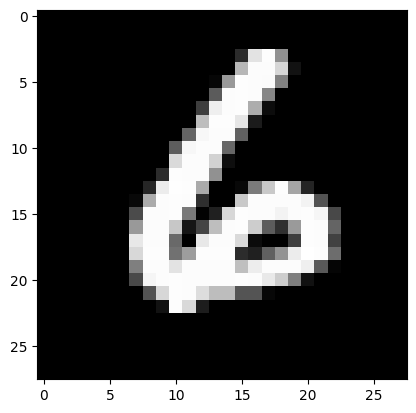

5


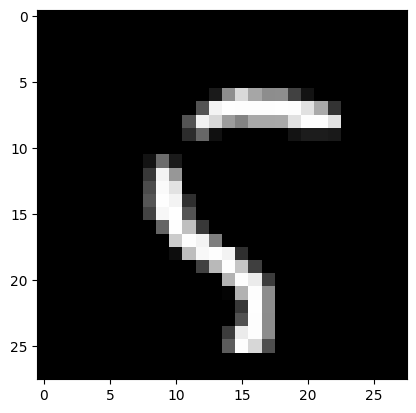

1


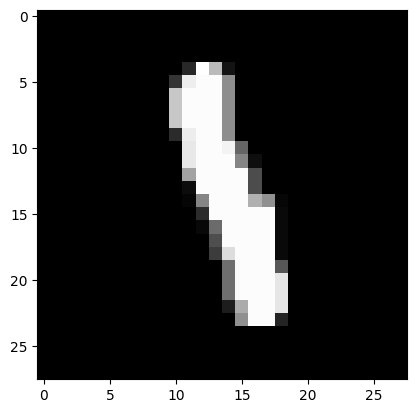

7


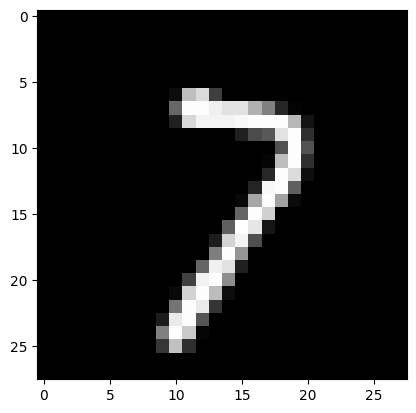

4


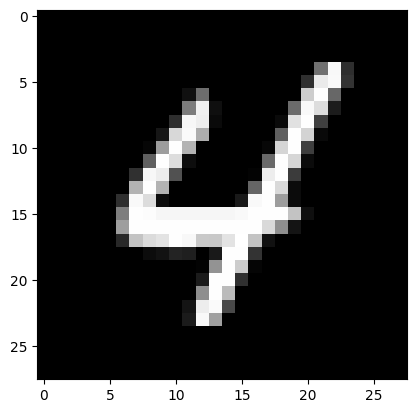

8


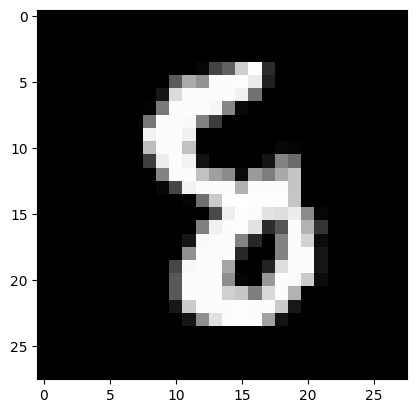

8


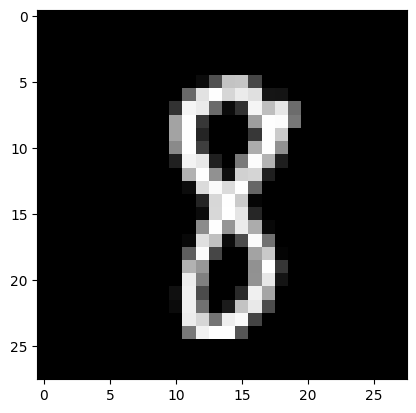

6


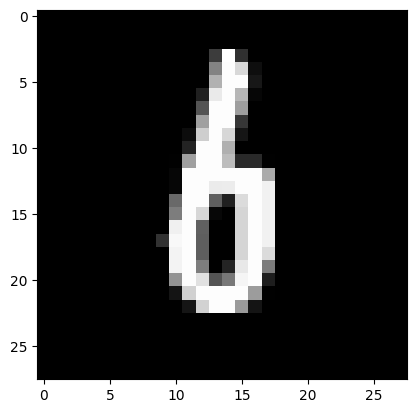

6


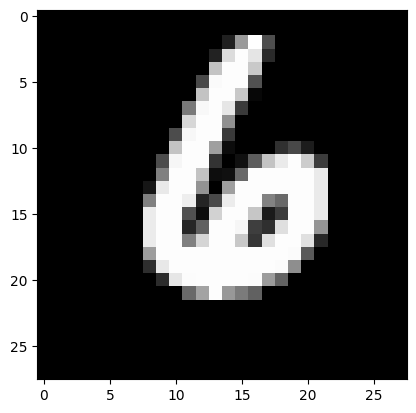

8


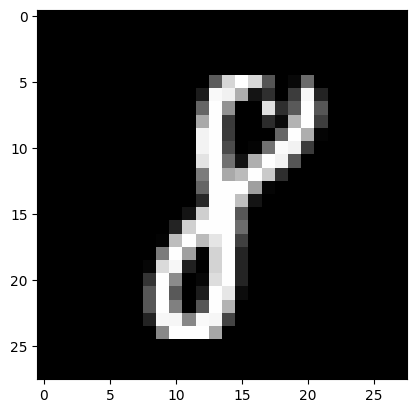

8


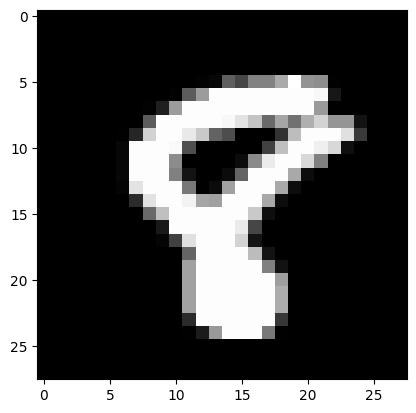

1


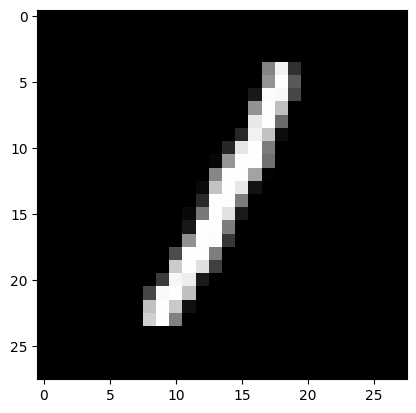

2


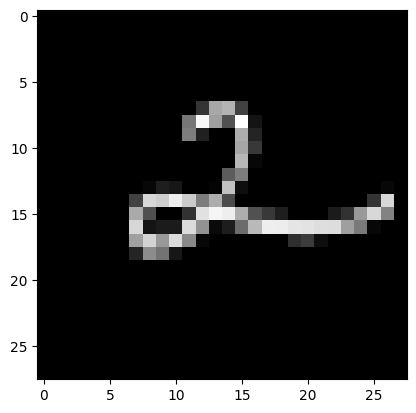

4


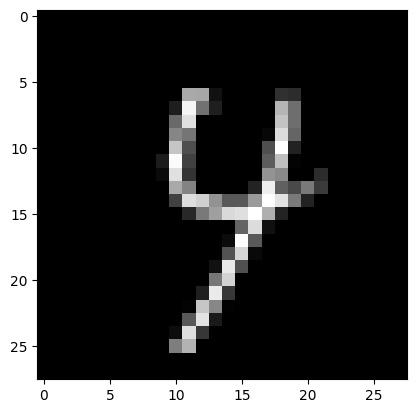

7


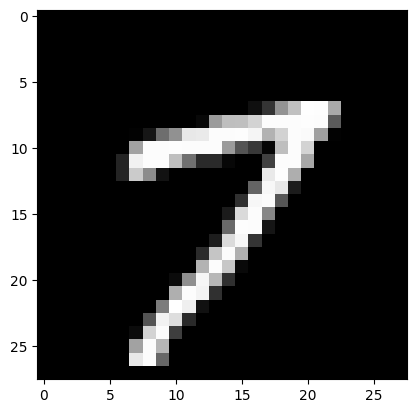

0


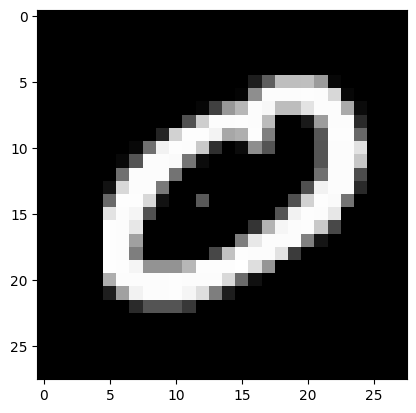

1


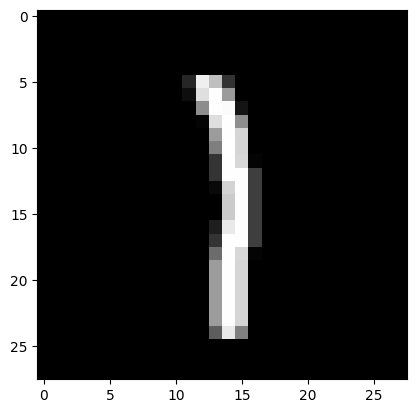

0


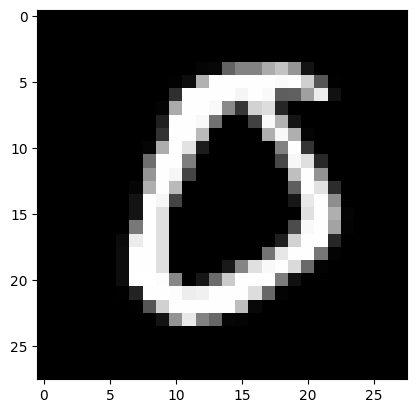

6


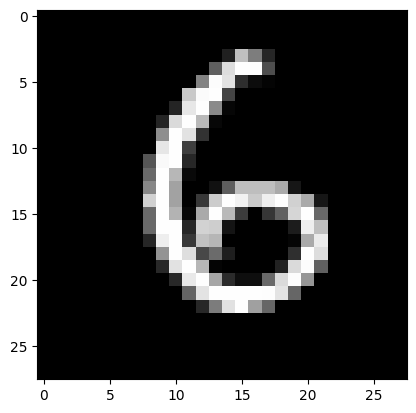

8


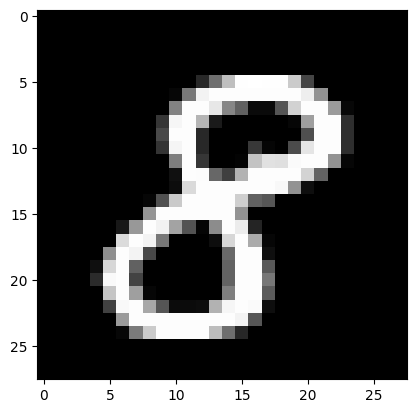

2


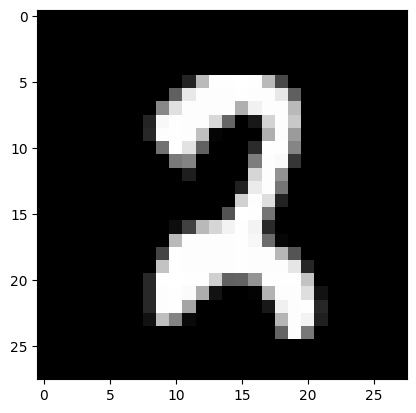

9


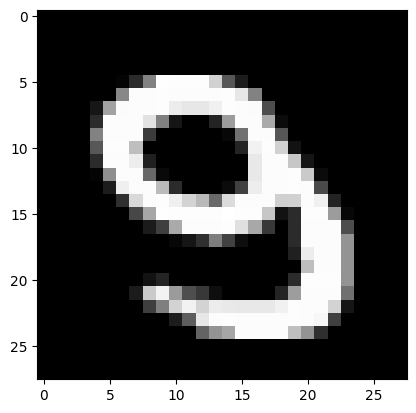

2


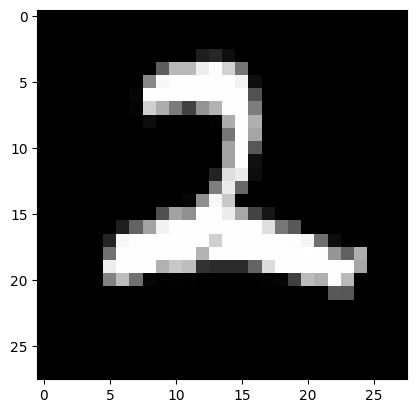

5


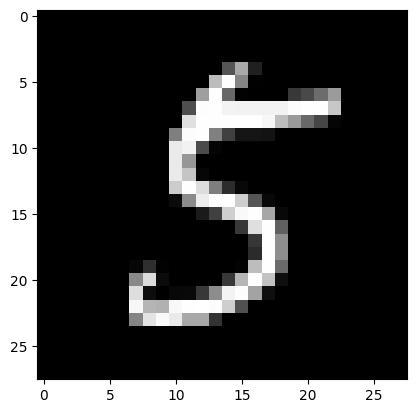

1


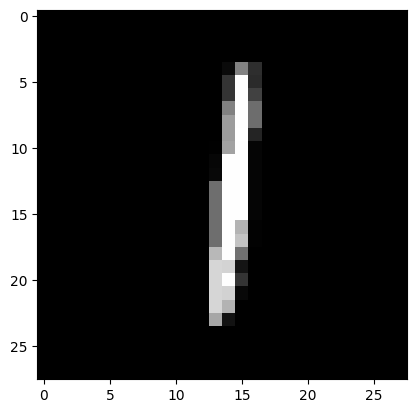

9


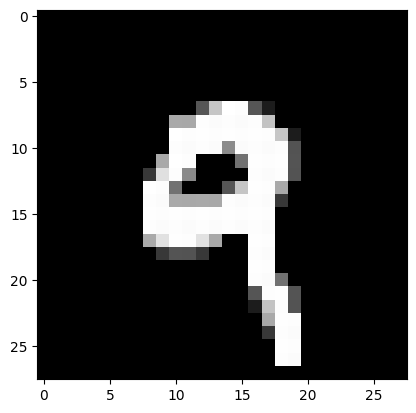

4


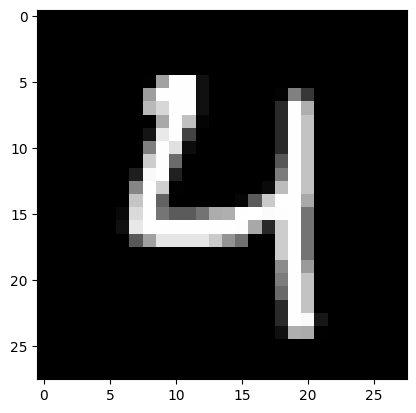

6


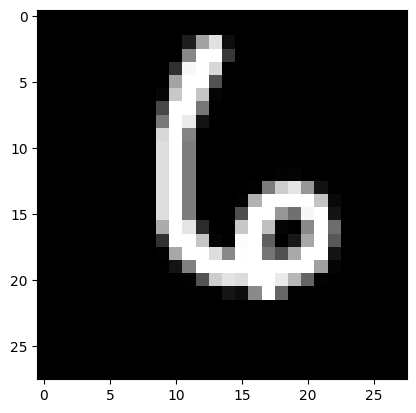

2


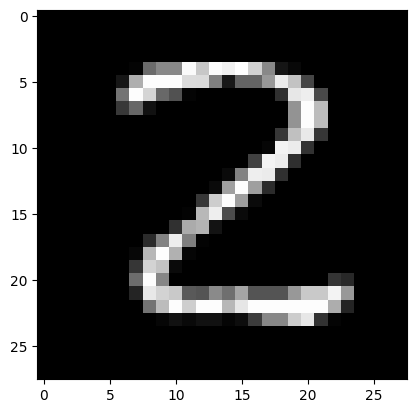

6


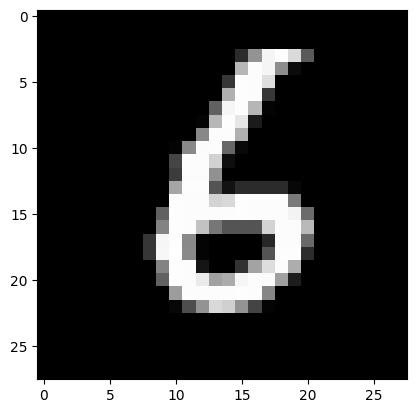

1


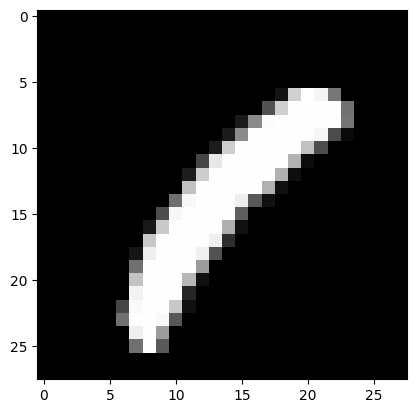

3


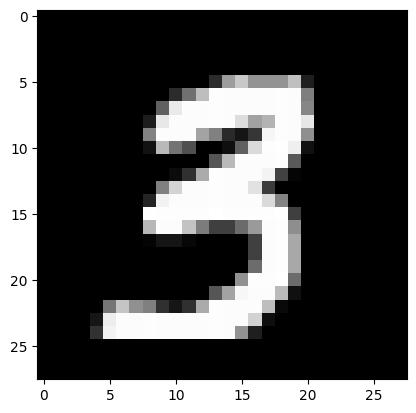

7


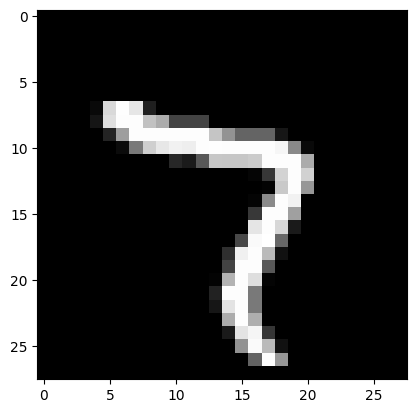

In [22]:
import matplotlib.pyplot as plt 
import numpy as np 

for i in range(0, 100, 2):
    print(prediction[i])
    shape =(28, 28)
    cmap = plt.get_cmap('gray')
    plt.imshow(np.reshape(test.iloc[i], shape), cmap=cmap)
    plt.show()

## **Evaluation**

In [25]:
accuracy = accuracy_score(Y_val, Y_pred)
accuracy

0.9926785714285714

In [23]:
Y_preds_val = knn.predict(X_val)
print(classification_report(Y_val, Y_preds_val))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1116
           1       0.99      1.00      1.00      1244
           2       0.99      0.99      0.99      1094
           3       0.99      0.99      0.99      1185
           4       0.99      0.99      0.99      1073
           5       0.99      0.99      0.99      1035
           6       0.99      1.00      1.00      1111
           7       0.99      0.99      0.99      1163
           8       1.00      0.98      0.99      1080
           9       0.99      0.99      0.99      1099

    accuracy                           0.99     11200
   macro avg       0.99      0.99      0.99     11200
weighted avg       0.99      0.99      0.99     11200



Saving figure kNN-PCA Confusion Matrix


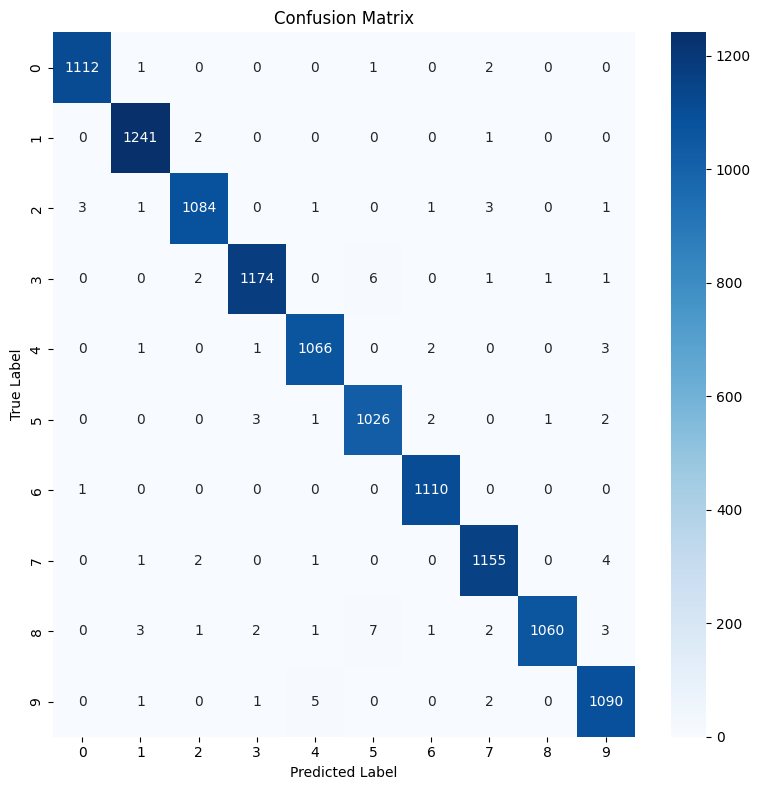

In [24]:
cm = confusion_matrix(Y_val, Y_preds_val)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(Y_val), yticklabels=np.unique(Y_val))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
save_fig("kNN-PCA Confusion Matrix")
plt.show()